## Q2 - Template Matching

In [69]:
# import our needed libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random 
from numba import jit
import time 
plt.rcParams['figure.figsize'] = (20, 10)


# Define our needed functions -------------------------------
# function for reading an image from its path
def reading_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# showing an image by matplotlib library
def showing_image(image): 
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.show()

# function for detecting edges
def edge_detection(image, th1=100, th2=500): 
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)
    image_output = cv2.Canny(image_blurred, th1, th2)
    return image_output

# fill free blank of edges 
@jit
def drawing_edges(img_in):
    w, l = img_in.shape
    h = 30 
    Th = 10
    img_out = np.zeros(shape = (w, l))
    for i in range(w):
        for j in range(l-h-1):
            # check for pixels before current one. 
            before_flag = False
            for k in range(h):
                if img_in[i, j-k] > Th:
                    before_flag = True
            
            # check for pixels after current one. 
            after_flag = False
            for k in range(h):
                if img_in[i, j+k] > Th: 
                    after_flag = True
                    
            if before_flag & after_flag:
                img_out[i, j] = 255
    
    return img_out

# function for find elements such as template
@jit
def drawing_edges2(img_org, RTh1=20, RTh2=100, GTh1=0, GTh2=255, BTh1=0, BTh2=255):
    img = img_org.copy()
    w, l, _ = img_org.shape
    img_out = np.zeros(shape=(w, l))
    
    for i in range(w):
        for j in range(l):
            R_case = (img[i, j, 0] > RTh1) & (img[i, j, 0] < RTh2)
            G_case = (img[i, j, 1] > GTh1) & (img[i, j, 1] < GTh2)
            B_case = (img[i, j, 2] > BTh1) & (img[i, j, 2] < BTh2)
            if R_case & G_case & B_case:
                img_out[i, j] = 255
    
    return img_out


# this function is for template matching
def template_matching(img_org, img_tmp, random_p=10000, k=1, step=4, Th1=2, Th2=100, x1=100, y1=100, x2=3000-100, y2=3000-100, gray_flag=False):    
    # convert the input images from RGB to grayscale format
    if not gray_flag:
        img_org = cv2.cvtColor(img_org, cv2.COLOR_RGB2GRAY)
        img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_RGB2GRAY)
    
    # create a list including all possibles pixels to check matching
    pixels = [(i, j) for i in range(x1, x2, k) for j in range(y1, y2, k)]
    pixels_len = int(np.ceil((x2 - x1) / k) * np.ceil((y2 - y1) / k))
    
    # crop center part of the tmp image to reduce time complexity
    w1, l1 = img_tmp.shape
    l2 = np.min((60, l1))
    w2 = np.min((350, w1))
    img_tmp_center = img_tmp[int(w1/2 - w2/2):int(w1/2 + w2/2), int(l1/2 - l2/2):int(l1/2 + l2/2)]
    
    # set initial variabls
#     min_score = np.inf
    best_x = 0
    best_y = 0 
    score = 0 
    best_img = 0 
    result = []
    
    # loop over pixels randomly
    for i in range(np.min((pixels_len, random_p))):
        
        # pick a random pixel to check matching 
        indx = random.randint(0, pixels_len - i - 1)
        pixel = pixels.pop(indx)
        pixel_x = pixel[0]
        pixel_y = pixel[1]
        img = img_org[pixel_x:pixel_x+w2, pixel_y:pixel_y+l2]
        
        # Cross Corelation to check matching
        score = np.sum((img - img_tmp_center) ** 2)
        if score < Th2:
            x = int(pixel_x - w1/2 + w2/2)
            y = int(pixel_y - l1/2 + l2/2)
            result.append((x, y, score))
            
        # if it is close to the locatoin check its neigbors
        if score < Th1 * Th2:
            for i in range(1, k, step):
                for j in range(1, k, step):
                    x = pixel_x + i
                    y = pixel_y + j 
                    img = img_org[x : x + w2, y : y + l2]
                    score = np.sum((img - img_tmp_center) ** 2)
                    
                    if score < Th2:
                        x = int(x - w1/2 + w2/2)
                        y = int(y - l1/2 + l2/2)
                        result.append((x, y, score))
                
            
        
    print('pixels to check : ', pixels_len)
#     result = (best_x, best_y, w2, l2, img_tmp_center, best_img, min_score)
    return result  

# draw a rectangle for each template matching
def draw_results(result, img_org_edge, img_tmp, x_error=10, y_error=10, x1=100, y1=100, x2=3000-100, y2=3000-100):
    # temp img
    w = img_tmp.shape[0]
    l = img_tmp.shape[1]
    
    # sort result
    result.sort(key=lambda x:x[2])
    
    # show the box of original image
    img = img_org_edge.copy()
    cv2.rectangle(img, (y1, x1), (y2, x2), (255, 0, 0), 2)

    added_recs = []
    # show the best matching
    for pic in result: 
        disagree = False
        x = pic[0]
        y = pic[1]
        score = pic[2]
        
        # check for adding a rectangle just in new places
        if (y < 1585) & (y > 1545):
            for rec in added_recs:
                if (np.abs(rec[0] - x) < x_error) & (np.abs(rec[1] - y) < 5):
                    disagree = True
        else:
            for rec in added_recs:
                if (np.abs(rec[0] - x) < x_error) & (np.abs(rec[1] - y) < y_error):
                    disagree = True
            
        
        if not disagree: 
            cv2.rectangle(img, (y, x), (y + l, x + w), (255, 255, 0), 2)
            added_recs.append((x, y))

            # check pixels list
#             print('x : ', pic[0])
#             print('y : ', pic[1])
#             print('score : ', pic[2])
#             print('---------------')
    
    return img


/tmp/ipykernel_7285/504577661.py:32: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def drawing_edges(img_in):
/tmp/ipykernel_7285/504577661.py:58: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def drawing_edges2(img_org, RTh1=20, RTh2=100, GTh1=0, GTh2=255, BTh1=0, BTh2=255):


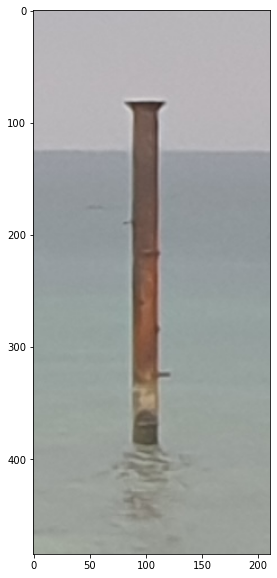

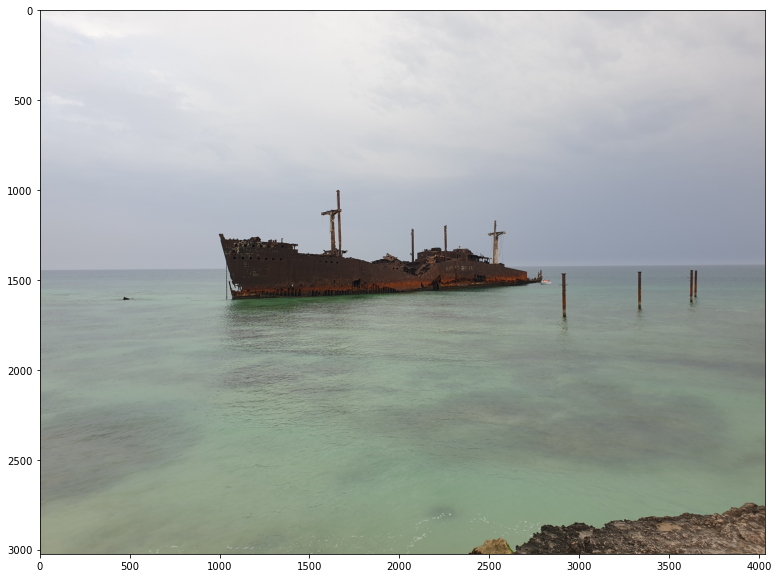

In [70]:
# Reading our images
img_tmp = reading_image('patch.png')
img_org = reading_image('Greek-ship.jpg')

# Showing the images
showing_image(img_tmp)
showing_image(img_org)

pixels to check :  962
execution time :  3.886803150177002


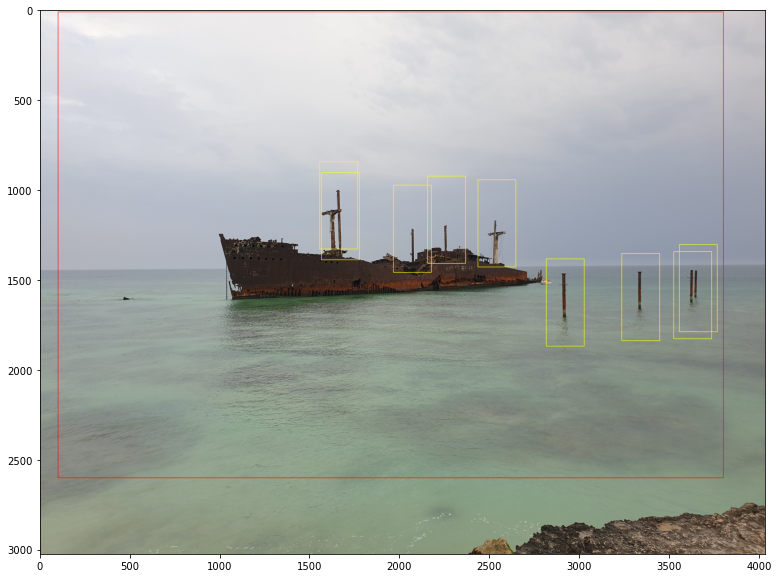

done!
template : 


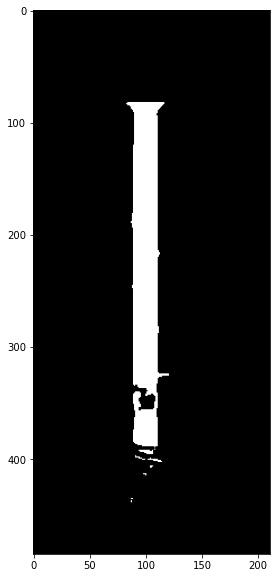

template center : 


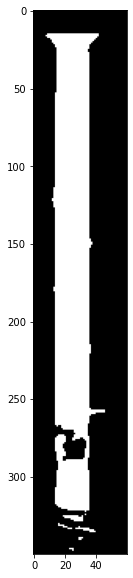

True

In [91]:

img1 = drawing_edges2(img_org)
# showing_image(img1)

img2 = drawing_edges2(img_tmp, RTh1=0, RTh2=180, GTh1=0, GTh2=140, BTh1=0, BTh2=110)
w, l = img2.shape

# set initial variables 
x1 = 10
y1 = 100 
x2 = 2600
y2 = 3800

# run the function
start_time = time.time()
result = template_matching(img1, img2,random_p=100000, k=100, step=10, Th1=1.19, Th2=410000000, x1=x1, y1=y1, x2=x2, y2=y2, gray_flag=True)
end_time = time.time()
print('execution time : ', end_time-start_time)

img_out = draw_results(result, img_org, img_tmp, x_error=400, y_error=20, x1=x1, y1=y1, x2=x2, y2=y2)
showing_image(img_out)
    
# showing_image(img)
print("done!")

# show center of the template
print('template : ')
showing_image(img2)
print('template center : ')

w1, l1 = img2.shape
l2 = np.min((60, l1))
w2 = np.min((350, w1))
img_tmp_center = img2[int(w1/2 - w2/2):int(w1/2 + w2/2), int(l1/2 - l2/2):int(l1/2 + l2/2)]
showing_image(img_tmp_center)

# save result
result11 = cv2.cvtColor(img_out, cv2.COLOR_RGB2BGR)
cv2.imwrite('result11.jpg', result11)


